# Modeling Thermodynamic Cycles in Python

This exercise simulates a Rankine power plant cycle using the TESPy package in Python. TESPy stands for "Thermal Engineering Systems in Python" and provides a simulation toolkit for thermal engineering plants such as power
plants, district heating systems or heat pumps. It is an external extension
module within the Open Energy Modelling Framework `oemof <https://oemof.org/>`_
and can be used as a standalone package.

Examples and documentation in [TESPy](https://github.com/oemof/tespy). Find more information
about the modelling feature in the respective [online documentation](https://tespy.readthedocs.io/en/main/).

BibTeX citation:

    @article{Witte2020,
        doi = {10.21105/joss.02178},
        year = {2020},
        publisher = {The Open Journal},
        volume = {5},
        number = {49},
        pages = {2178},
        author = {Francesco Witte and Ilja Tuschy},
        title = {{TESPy}: {T}hermal {E}ngineering {S}ystems in {P}ython},
        journal = {Journal of Open Source Software}
    }

## Authors

The authors of this exercise are:

- Amedeo Ceruti
- Urbano Tataranni
- Hassan Hussein
- Jihad Jundi

## This exercise

This exercise details the steps and provides the necessary explanations for simulating a Rankine power plant.

### Basic Rankine Cycle

The simulation begins with a basic cycle, and then upgrades it by incorporating a reheat stage. This includes creating a fluid network, configuring the main components such as the cycle closer, pump, condenser, turbine, and heat exchanger, establishing and configuring connections between the components, and setting operational conditions and efficiency parameters. The next step is to solve the thermodynamic model of the basic cycle and analyze the results obtained from the simulation.

## 0. Basic Cycle

Examine the diagram of the simple Rankine turbine cycle and draw it in a T-s diagram
on a piece of paper. 

![Representation of the cycle under examination](figs/Rankine_simple.png)

In [32]:
%pip install tespy
from tespy.networks import Network
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


The Network of our plant is created below. All the required components are called from the library and, since 6 components for a Rankine cycle are used:

- Feed water Pump
- Condenser for heat removal,
- Turbine for extracting work,
- SimpleHeatExchanger for simulating heat flow from the solar collector system to the working fluid,
- Source,
- Sink,
- CyclerCloser.

The component *CyclerCloser* is used to set the condition of closed system process, because the system of equations describing the system will be overdetermined if a cycle is closed without this component. More information about other component can be consulted in the [online documentation](https://tespy.readthedocs.io/en/main/).

In [33]:
# import needed components form tespy
from tespy.components import (
    CycleCloser, Pump, Condenser, Turbine, SimpleHeatExchanger, Source, Sink
)

In [34]:
# create a network object with water as fluid
my_plant = Network()
my_plant.units.set_defaults(temperature='°C', pressure='bar', enthalpy='kJ / kg')

# store components in variables
cc = CycleCloser('cycle closer')
sg = SimpleHeatExchanger('steam generator')
mc = Condenser('main condenser')
tu = Turbine('steam turbine')
fp = Pump('feed pump')

cwso = Source('cooling water source')
cwsi = Sink('cooling water sink')

Now we establish connections between the various components of the Rankine cycle using TESpy's logic. The label is used as shown in the figure above.

In [35]:
from tespy.connections import Connection

In [36]:
c1 = Connection(cc, 'out1', tu, 'in1', label='1')
c2 = Connection(tu, 'out1', mc, 'in1', label='2')
c3 = Connection(mc, 'out1', fp, 'in1', label='3')
c4 = Connection(fp, 'out1', sg, 'in1', label='4')
c0 = Connection(sg, 'out1', cc, 'in1', label='0')

my_plant.add_conns(c1, c2, c3, c4, c0)

Additional connections are set up for the cooling water loop through the condenser.

- `c11` connects the outlet of the cooling water source (`cwso`) to the secondary inlet of the main condenser (`mc`).
- `c12` connects the secondary outlet of the main condenser (`mc`) to the inlet of the cooling water sink (`cwsi`).

These connections (`c11` and `c12`) are again added to the network as before.

In [37]:
c11 = Connection(cwso, 'out1', mc, 'in2', label='11')
c12 = Connection(mc, 'out2', cwsi, 'in1', label='12')

my_plant.add_conns(c11, c12)

## The Andasol Power Plant

The Andasol I and II power plants are parabolic through concentrating
solar thermal systems located in southern Spain and built in 2007:

- [Andasol 2 entry in the SolarPACES database](https://solarpaces.nrel.gov/project/andasol-2)
- [General information on the power plant](http://large.stanford.edu/publications/power/references/docs/Andasol1-3engl.pdf)

The original power plant specifications and results are obtained from the following
publication:
- [Andasol-2 Parabolic Trough Steam Ranking Cycle](https://doi.org/10.1016/j.jprocont.2016.01.002)

## 1.1 Read the information about Andasol and fill out the table below?

Use the paper above.

| Andasol II               | HP turbine   | Variable name |
|--------------------------|--------------|--------------|
| Conditions at the inlet  | P = *X* bar  | P_tu_in |
|                          | T = ... °C   | T_tu_in |
|                          | ṁ= ... kg/s  | mf   | 
| Conditions at the outlet | P = ... bar | p_tu_out |
|                          | T = ... °C    | -   | 

## 1.2 Store the parameter values in variables

Use the variable names `T_tu_in`, `p_tu_in`, `mf`, `p_tu_out`.

Assume a cooling water outlet temperature (`T_coo_out`) of 26 °C and an inlet (`T_coo_in`) one of 16 °C

In [ ]:
T_tu_in = X       # temperature turbine inlet
p_tu_in = ...       # pressure turbine inlet
mf = ...             # mass flow
p_tu_out = ...     # pressure turbine outlet

T_coo_in = ...       # temperature cooling water in
T_coo_out = ...      # temperature cooling water out

## Setting Attributes in TESpy

Now we transfer the parameters stored in the variables above to the cycle in TESpy.

### Component Attributes

- `mc.set_attr(pr1=1, pr2=1)`: Sets the pressure ratio (`pr1` and `pr2`) for the main condenser (`mc`) to 1, meaning there is no pressure drop across the condenser.
- `sg.set_attr(pr=1)`: Sets the pressure ratio (`pr`) for the steam generator (`sg`) to 1, indicating no pressure drop.
- `tu.set_attr(eta_s=0.80)`: Sets the isentropic efficiency (`eta_s`) of the turbine (`tu`) to 80%.
- `fp.set_attr(eta_s=0.90)`: Sets the isentropic efficiency (`eta_s`) of the feed pump (`fp`) to 90%.


In [39]:
mc.set_attr(pr1=1, pr2=1)  # assume no pressure loss in condenser
sg.set_attr(pr=1)
tu.set_attr(eta_s=0.80)       # Turbine isentropic efficiency
fp.set_attr(eta_s=0.90)         # Feed pump isentropic efficiency

### Connection Attributes

- `c11.set_attr(T=T_coo_in, p=1.2, fluid={'water': 1})`: Sets the temperature (`T`), pressure (`p`), and fluid composition (`fluid`) for connection `c11`. The temperature is set to the cooling water inlet temperature (`T_coo_in`), pressure to 1.2 bar, and the fluid to water.
- `c12.set_attr(T=T_coo_out)`: Sets the temperature (`T`) for connection `c12` to the cooling water outlet temperature (`T_coo_out`).
- `c1.set_attr(T=T_tu_in, p=p_tu_in, m=mf, fluid={'water': 1})`: Sets the temperature (`T`), pressure (`p`), mass flow rate (`m`), and fluid composition (`fluid`) for connection `c1`. The temperature is set to the turbine inlet temperature (`T_tu_in`), pressure to the turbine inlet pressure (`p_tu_in`), mass flow rate to `mf`, and the fluid to water.
- `c2.set_attr(p=p_tu_out)`: Sets the pressure (`p`) for connection `c2` to the turbine outlet pressure (`p_tu_out`).

In [40]:
c11.set_attr(T=T_coo_in, p=1.2, fluid={'water': 1})
c12.set_attr(T=T_coo_out)
c1.set_attr(T=T_tu_in, p=p_tu_in, m=mf, fluid={'water': 1})
c2.set_attr(p=p_tu_out)

### Power bus configuration

Finally, a bus that functions as an energy balance constraint, tracks the electrical power output of the system. A PowerBus is defined by adding components to this bus to account for their contributions to the electrical power generation and consumption.

In [41]:
from tespy.components import PowerBus, PowerSink, Motor, Generator
from tespy.connections import PowerConnection

electricity = PowerBus("electricity bus", num_in=1, num_out=2)
grid = PowerSink("grid")
motor = Motor("feed water pump motor")
generator = Generator("turbine generator")

e1 = PowerConnection(tu, "power", generator, "power_in", label="e1")
e2 = PowerConnection(generator, "power_out", electricity, "power_in1", label="e2")
e3 = PowerConnection(electricity, "power_out1", motor, "power_in", label="e3")
e4 = PowerConnection(motor, "power_out", fp, "power", label="e4")
e5 = PowerConnection(electricity, "power_out2", grid, "power", label="e5")

my_plant.add_conns(e1, e2, e3, e4, e5)

generator.set_attr(eta=0.98 * 0.95)
motor.set_attr(eta=0.97)

# track power output to the grid
e5.set_attr(E=None)

## Solve the Cycle

In [42]:
my_plant.set_attr(iterinfo=True)
my_plant.solve(mode='design')


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 9.93e+07   | 0 %        | 2.53e+03   | 0.00e+00   | 1.52e+06   | 0.00e+00   | 9.30e+07   
 2     | 2.69e+07   | 0 %        | 5.90e-07   | 0.00e+00   | 1.94e+05   | 0.00e+00   | 3.79e+07   
 3     | 1.62e+06   | 0 %        | 8.15e-09   | 0.00e+00   | 4.36e+04   | 0.00e+00   | 6.14e+03   
 4     | 1.62e+06   | 0 %        | 1.28e-13   | 0.00e+00   | 4.36e+04   | 0.00e+00   | 7.71e-08   
 5     | 2.40e+00   | 62 %       | 3.34e-10   | 0.00e+00   | 2.67e+00   | 0.00e+00   | 2.10e+02   
 6     | 3.82e-08   | 100 %      | 1.11e-13   | 0.00e+00   | 7.01e-10   | 0.00e+00   | 3.96e-08   
 7     | 2.80e-08   | 100 %      | 2.45e-13   | 0.00e+00   | 4.69e-10   | 0.00e+00   | 5.48e-09   
Total iterations: 7, Calculation time: 0.03 s, Iterations per second: 273.99


## 1.3 Describe the iteration information of the solving process in your own words.

If needed, consult the tespy documentation!

### Results output

Solving command launched by printing simulation results without information about iteration steps by using *.print_results()*.

In [43]:
my_plant.print_results()


##### RESULTS (CycleCloser) #####
+--------------+------------------+-------------------+
|              |   mass_deviation |   fluid_deviation |
|--------------+------------------+-------------------|
| cycle closer |         0.00e+00 |          0.00e+00 |
+--------------+------------------+-------------------+
##### RESULTS (Pump) #####
+-----------+----------+----------+-----------+----------+
|           |        P |       pr |        dp |    eta_s |
|-----------+----------+----------+-----------+----------|
| feed pump | 6.26e+05 | 2.08e+03 | -1.04e+02 | 9.00e-01 |
+-----------+----------+----------+-----------+----------+
##### RESULTS (Motor) #####
+-----------------------+----------+---------------+
|                       |      eta |   delta_power |
|-----------------------+----------+---------------|
| feed water pump motor | 9.70e-01 |      1.93e+04 |
+-----------------------+----------+---------------+
##### RESULTS (Condenser) #####
+----------------+-----------+--------

## 1.4 Calculate the Efficiency of the Cycle

Hints:
- Might be necessary to use absolute values (`abs()`) when needed
- You can use the the attribute added to the net electricity output to the grid in `e5`
- Our use the LES-Formelsammlung from Moodle to calculate it by hand from the enthalpy balances. 

In [ ]:
# Calculate net work output (electrical power generated by the turbine exported to grid)
W_net = ...

# Calculate heat input to the cycle (heat supplied to the steam generator)
Q_in = ...

# Calculate thermal efficiency of the cycle
thermal_efficiency = ...

print(f"Thermal efficiency of the simple cycle: {round(thermal_efficiency * 100, 2)} %")

## 1.5 Compare the efficiency of the simple cycle and brainstorm ways to improve it

- *Reheat heat exchanger*
- ...

## 1.6 Increasing the turbine inlet temperature

What temperatures can be reached? What efficiency would you obtain now?

Assume the thermal fluid is changed to operate with molten salts, but change only the
input temperature in the turbine (`c1.set_attr(T=...)`)

In [ ]:
T_tu_in = ...       # temperature turbine inlet
c1.set_attr(T=T_tu_in)
my_plant.solve(mode='design')


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.49e+07   | 0 %        | 3.18e+02   | 0.00e+00   | 2.46e+05   | 0.00e+00   | 1.59e+07   
 2     | 1.62e+06   | 0 %        | 7.30e-10   | 0.00e+00   | 4.36e+04   | 0.00e+00   | 2.10e+02   
 3     | 1.62e+06   | 0 %        | 4.97e-10   | 0.00e+00   | 4.36e+04   | 0.00e+00   | 5.83e-09   
 4     | 1.62e+06   | 0 %        | 4.96e-10   | 0.00e+00   | 4.36e+04   | 0.00e+00   | 2.00e-08   
 5     | 2.40e+00   | 62 %       | 6.59e-10   | 0.00e+00   | 2.67e+00   | 0.00e+00   | 2.10e+02   
 6     | 1.54e-08   | 100 %      | 3.01e-13   | 0.00e+00   | 5.47e-10   | 0.00e+00   | 3.38e-08   
 7     | 7.96e-09   | 100 %      | 3.01e-13   | 0.00e+00   | 2.40e-10   | 0.00e+00   | 1.32e-08   
Total iterations: 7, Calculation time: 0.03 s, Iterations per second: 255.09


In [ ]:
W_net = ....
thermal_efficiency = ...

print(f"Thermal efficiency of the simple cycle: {round(thermal_efficiency * 100, 2)} %")

## 1.7 T-s diagram Analysis

What issue is arising when the simple cycle is plotted?

In [47]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.style as mplstyle

In [48]:
# Load the Excel file containing the thermodynamic tables into a Pandas DataFrame
file_path = 'Data/Steamtables.xlsx'
df = pd.read_excel(file_path, sheet_name='Tabelle1')

# Extracting the data
temperature = df['T (°C)']
sv = df['SV [kJ/(kg K)]']
sl = df['SL [kJ/(kg K)]']

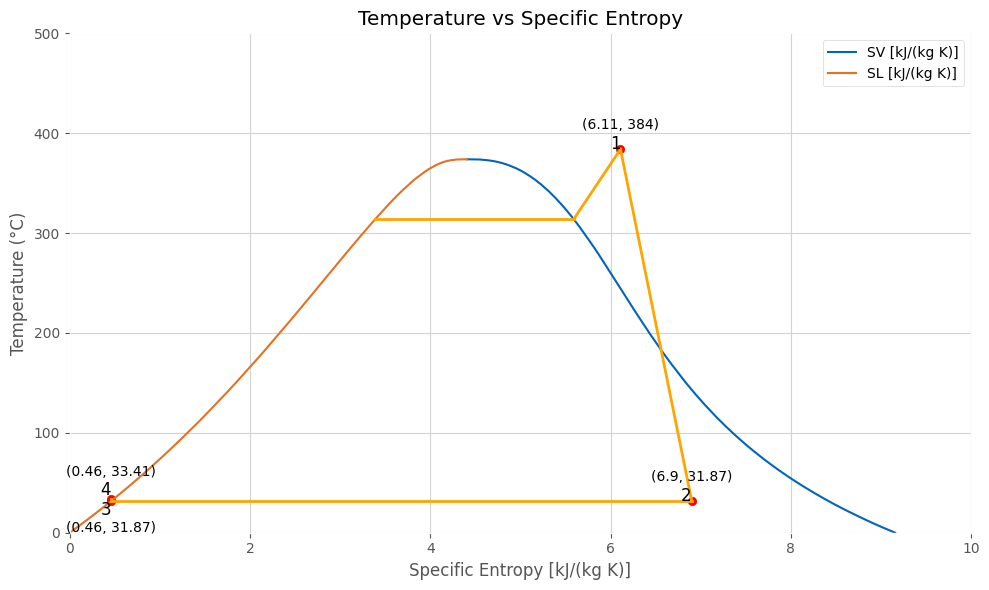

In [49]:
with mplstyle.context('ggplot', after_reset=False):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = 'white'
    # Plotting SL and SV against Temperature from steam tables
    plt.plot(sv, temperature, label='SV [kJ/(kg K)]', color="#0065bd")
    plt.plot(sl, temperature, label='SL [kJ/(kg K)]', color="#e37222")
    
    # Labeled points and intermediate points
    points = [(6.110, 384), (6.9, 31.87), (0.46, 31.87), (0.46, 33.41)]
    intermediate_points = [(3.389, 313.9), (5.591, 313.9)]
    labels = ['1', '2', '3', '4']
    
    # Plotting labeled points with red dots
    for i, ((x, y), label) in enumerate(zip(points, labels)):
        plt.scatter(x, y, color='red')
        if i == 2:  # For point 3
            plt.text(x, y, label, fontsize=12, ha='right', va='top')  # Label below
            plt.text(x, y - 20, f'({x}, {y})', fontsize=10, ha='center', va='top')  # Coordinates below
        elif i == 3:  # For point 4
            plt.text(x, y, label, fontsize=12, ha='right', va='bottom')  # Label above
            plt.text(x, y + 20, f'({x}, {y})', fontsize=10, ha='center', va='bottom')  # Coordinates above
        else:  # For other points
            plt.text(x, y, label, fontsize=12, ha='right')
            plt.text(x, y + 20, f'({x}, {y})', fontsize=10, ha='center')
    
    # Connecting the labeled points with lines
    for i in range(len(points) - 1):
        plt.plot([points[i][0], points[i + 1][0]], [points[i][1], points[i + 1][1]], color='orange', linestyle='-', linewidth=2)
    
    # Connecting the last point to the first point via intermediate points
    
    plt.plot([intermediate_points[0][0], intermediate_points[1][0]], [intermediate_points[0][1], intermediate_points[1][1]], color='orange', linestyle='-', linewidth=2)
    plt.plot([intermediate_points[1][0], points[0][0]], [intermediate_points[1][1], points[0][1]], color='orange', linestyle='-', linewidth=2)
    
    # Setting axis limits
    plt.xlim(0, 10)
    plt.ylim(0, 500)
    
    # Labels and title
    plt.xlabel('Specific Entropy [kJ/(kg K)]')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature vs Specific Entropy')
    plt.legend()
    
    # Grid and layout
    plt.grid(True, color="#D3D3D3")
    plt.tight_layout()
    
    # Show plot
    plt.savefig(r'figs\Cycle_simple.svg', format='svg', dpi=300)
    plt.show()

## 2. Rankine Cycle with Reheat

This following section presents an enhanced version of the Rankine cycle simulation, incorporating a reheat stage to improve efficiency and performance.

![Representation of the cycle under examination](figs/Rankine_complete.png)

In [50]:
rankine = Network()
rankine.units.set_defaults(temperature='°C', pressure='bar', enthalpy='kJ / kg')

- **`sgre = SimpleHeatExchanger('steam generator for reheating')`:** This creates a new instance of a SimpleHeatExchanger component named `sgre`, representing a steam generator dedicated to reheating. Its purpose is to reheat the steam generated in the main steam generator before it enters the low-pressure turbine. To simplify the system, it is modeled
as a separate heat exchanger instead of integrating it into the steam generator.

- **`tuhp = Turbine('steam turbine HP')` and `tulp = Turbine('steam turbine LP')`:** These lines create instances of Turbine components named `tuhp` and `tulp`, representing the high-pressure and low-pressure turbines, respectively. These turbines are responsible for converting the thermal energy of steam into mechanical work. The designation of HP and LP indicates their positions in the cycle, with the HP turbine operating on high-pressure steam and the LP turbine operating on low-pressure steam.

In [51]:
sgre = SimpleHeatExchanger('steam generator for reheating')
tuhp = Turbine('steam turbine HP')
tulp = Turbine('steam turbine LP')
gen_h = Generator("generator HP")
gen_l = Generator("generator LP")
motor = Motor("feed water pump motor")
grid = PowerSink("grid")

c1 = Connection(cc, 'out1', tuhp, 'in1', label='1')
c2 = Connection(tuhp, 'out1', sgre, 'in1', label='2')
c3 = Connection(sgre, 'out1', tulp, 'in1', label='3')
c4 = Connection(tulp, 'out1', mc, 'in1', label='4')
c5 = Connection(mc, 'out1', fp, 'in1', label='5')
c6 = Connection(fp, 'out1', sg, 'in1', label='6')
c0 = Connection(sg, 'out1', cc, 'in1', label='0')

c11 = Connection(cwso, 'out1', mc, 'in2', label='11')
c12 = Connection(mc, 'out2', cwsi, 'in1', label='12')

rankine.add_conns(c1, c2, c3, c4, c5, c6, c0, c11, c12)

In [52]:
mc.set_attr(pr1=1, pr2=1)       # Pressure losses in the condenser
sg.set_attr(pr=0.9)             # Pressure losses in the heating process
sgre.set_attr(pr=0.946)         # Pressure losses in the reheating process
tuhp.set_attr(eta_s=0.80)       # HP Turbine isentropic efficiency
tulp.set_attr(eta_s=0.80)       # LP Turbine isentropic efficiency
fp.set_attr(eta_s=0.90)         # Feed pump isentropic efficiency

## 2.1 Define the new boundary conditions for the cycle based on the table below.

Add them to the cycle by orienting yourself with the basic cycle.

| Andasol II               | HP turbine   | LP turbine     |
|--------------------------|--------------|----------------|
| Conditions at the inlet  | P = 104 bar  | P =  bar   |
|                          | T = 384 °C   | T =  °C |
|                          | ṁ = 54 kg/s  | ṁ =  kg/s    |
| Conditions at the outlet | P = 20.5 bar | P =  bar   |
|                          | T = 215 °C   | T =  °C      |

In [ ]:
# Use previous variables wherever possible, since they are unchanged
c11.set_attr(T=T_coo_in, p=1.2, fluid={'water': 1})
c12.set_attr(T=T_coo_out)
c1.set_attr(T=T_tu_in, m=mf, p=p_tu_in, fluid={'water': 1})
c4.set_attr(p=p_tu_out)

# new parameters of the LP turbine
c3.set_attr(T=..., p=...)

In [54]:
powergen = PowerBus("electrical power output", num_in=2, num_out=2)

e1 = PowerConnection(tuhp, "power", gen_h, "power_in", label="e1")
e2 = PowerConnection(gen_h, "power_out", powergen, "power_in1", label="e2")
e3 = PowerConnection(tulp, "power", gen_l, "power_in", label="e3")
e4 = PowerConnection(gen_l, "power_out", powergen, "power_in2", label="e4")
e5 = PowerConnection(powergen, "power_out1", motor, "power_in", label="e5")
e6 = PowerConnection(motor, "power_out", fp, "power", label="e6")
e7 = PowerConnection(powergen, "power_out2", grid, "power", label="e7")

rankine.add_conns(e1, e2, e3, e4, e5, e6, e7)

gen_h.set_attr(eta=0.98 * 0.95)
gen_l.set_attr(eta=0.98 * 0.95)
motor.set_attr(eta=0.95)

e7.set_attr(E=None)  # track power output to the grid

In [55]:
rankine.set_attr(iterinfo=False)
rankine.solve(mode='design')
rankine.print_results()


##### RESULTS (CycleCloser) #####
+--------------+------------------+-------------------+
|              |   mass_deviation |   fluid_deviation |
|--------------+------------------+-------------------|
| cycle closer |         0.00e+00 |          0.00e+00 |
+--------------+------------------+-------------------+
##### RESULTS (Pump) #####
+-----------+----------+----------+-----------+----------+
|           |        P |       pr |        dp |    eta_s |
|-----------+----------+----------+-----------+----------|
| feed pump | 6.95e+05 | 2.31e+03 | -1.16e+02 | 9.00e-01 |
+-----------+----------+----------+-----------+----------+
##### RESULTS (Motor) #####
+-----------------------+----------+---------------+
|                       |      eta |   delta_power |
|-----------------------+----------+---------------|
| feed water pump motor | 9.50e-01 |      3.66e+04 |
+-----------------------+----------+---------------+
##### RESULTS (Generator) #####
+--------------+----------+-----------

## 2.2 Calculate the cycle efficiency

Neglect all parasitic power consumers (i.e. main pump, cooling towers, cooling fans, balance of plant, etc.)

In [ ]:
W_net = ...
Q_in = ...
thermal_efficiency = ...

print(f"Thermal efficiency of the cycle with reheat: {round(thermal_efficiency * 100, 2)} %")

## 2.3 Calculate the efficiency

Include:
1. power required for the main pump
2. wet and dry cooling electricity needs.

Assume the condensation temperature does not change:

- **Power Block Parasitics:**
  - **Wet Cooling:** 400 kW
  - **Dry Cooling:** 1500 kW

In [ ]:
W_net = ...
Q_in = ...
thermal_efficiency = ...

print(f"Thermal efficiency of the cycle with reheat (wet cooling): {round(thermal_efficiency * 100, 2)} %")

In [ ]:
# Calculate net # Calculate thermal efficiency of the cycle
thermal_efficiency = ...

print(f"Thermal efficiency of the cycle with reheat (dry cooling): {round(thermal_efficiency * 100, 2)} %")

## 2.4 What additional factors reduce the efficiency of dry cooling compared to wet cooling?

- *The higher back pressure in dry cooling systems reduces the thermodynamic efficiency of the Rankine cycle.*
- *Higher condensation temperature reduces delta T.*

## 2.5 T-s Diagram Analysis

What changed? Does a reheater increase the total heating power of the plant? What are the effects on the net output, and what economic trade-offs are needed?

*Increase in Qin, larger increase in the net power output due to increased total efficiency. The tradeoff here is more investment, larger amount of heat input vs. (hopefully) much more efficiency and therefore revenues - costs. The turbines show less two-phase sections. However, the LP needs to be optimized further according to our simplified calculations*

In [59]:
# Load the Excel file into a Pandas DataFrame
file_path = 'data\Steamtables.xlsx'
df_steam = pd.read_excel(file_path, sheet_name='Tabelle1')

# Extracting the data from steam tables
temperature = df_steam['T (°C)']
sv = df_steam['SV [kJ/(kg K)]']
sl = df_steam['SL [kJ/(kg K)]']

# New data with entropy values for specific states
data_states = {
    'State': [1, 2, 3, 4, 5, 6],
    'm': [54.0, 54.0, 54.0, 54.0, 54.0, 54.0],
    'p': [104.0, 20.51, 19.4, 0.05, 0.05, 115.6],
    'h': [3036.0, 2760.0, 3212.0, 2371.0, 137.7, 150.6],
    'T': [384.0, 213.6, 383.0, 32.87, 32.87, 32.87],
    's': [6.106, 6.25, 7.089, 7.774, 0.47889, 0.4804]
}

# Create DataFrame for the states data
df_states = pd.DataFrame(data_states)

# Extracting the temperature and entropy data for states
temperature_states = df_states['T']
entropy_states = df_states['s']

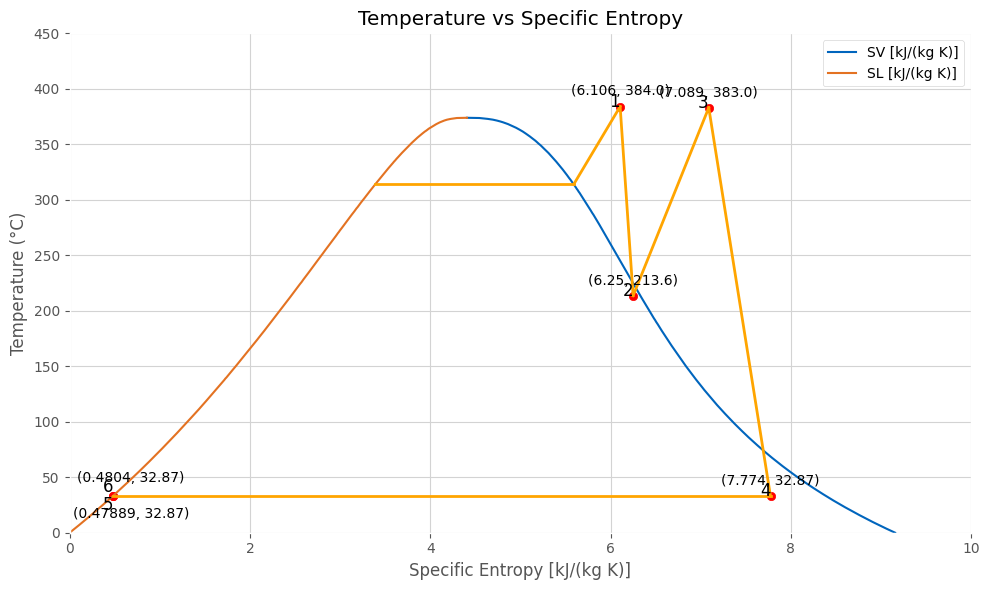

In [60]:
with mplstyle.context('ggplot', after_reset=False):
    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = 'white'
    # Plotting SV against Temperature from steam tables
    plt.plot(sv, temperature,
             label='SV [kJ/(kg K)]', color="#0065bd")
    
    # Plotting SL against Temperature from steam tables
    plt.plot(sl, temperature,
             label='SL [kJ/(kg K)]', color="#e37222")
    
    # Extracting points (entropy and temperature) and labels for states
    points = list(zip(entropy_states, temperature_states))
    labels = df_states['State']
    
    # Intermediate points for connecting lines (example points; adjust as needed)
    intermediate_points = [(5.591, 313.9), (3.389, 313.9)]
    
    # Plotting labeled points with red dots for states
    for i, (x, y) in enumerate(points):
        plt.scatter(x, y, color='red')  # Plotting red dots for each point
        # Adding labels and coordinates
        if labels[i] == 5:
            plt.text(x, y, f'{labels[i]}',
                     fontsize=12, ha='right', va='top')  # Label above point 5
            plt.text(x+0.2, y - 10, f'({x}, {y})',
                     fontsize=10, ha='center', va='top')  # Coordinates below point 5
        elif labels[i] == 6:
            plt.text(x, y, f'{labels[i]}',
                     fontsize=12, ha='right', va='bottom')  # Label below point 6
            plt.text(x+0.2, y + 10, f'({x}, {y})',
                     fontsize=10, ha='center', va='bottom')  # Coordinates above point 6
        else:
            plt.text(x, y, f'{labels[i]}', fontsize=12, ha='right')  # Label for other points
            plt.text(x, y + 10, f'({x}, {y})', fontsize=10, ha='center')  # Coordinates for other points
    
    # Connecting the labeled points with lines for states
    for i in range(len(points) - 1):
        plt.plot([points[i][0], points[i + 1][0]],
                 [points[i][1], points[i + 1][1]],
                 color='orange', linestyle='-', linewidth=2)
    
    # Connecting the first intermediate point to the second
    plt.plot([intermediate_points[0][0], intermediate_points[1][0]],
             [intermediate_points[0][1], intermediate_points[1][1]],
             color='orange', linestyle='-', linewidth=2)
    
    # Connecting Intermediate 1 to point 1
    plt.plot([intermediate_points[0][0], points[0][0]], [intermediate_points[0][1], points[0][1]],
             color='orange', linestyle='-', linewidth=2)
    
    # Setting axis limits for better visualization
    plt.xlim(0, 10)
    plt.ylim(0, 450)
    
    # Adding labels for axes and title
    plt.xlabel('Specific Entropy [kJ/(kg K)]')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature vs Specific Entropy')
    
    # Adding legend to the plot
    plt.legend()
    
    # Adding grid for better readability
    plt.grid(True, color="#D3D3D3")
    
    # Adjusting layout for better fit
    plt.tight_layout()
    
    # Displaying the plot
    plt.savefig(r'figs\Cycle_reheated.svg', format='svg', dpi=300)
    plt.show()

## Exkursus: advantages of having a simulation

Having a simulation of a cycle allows to do parameteric studies with ease.

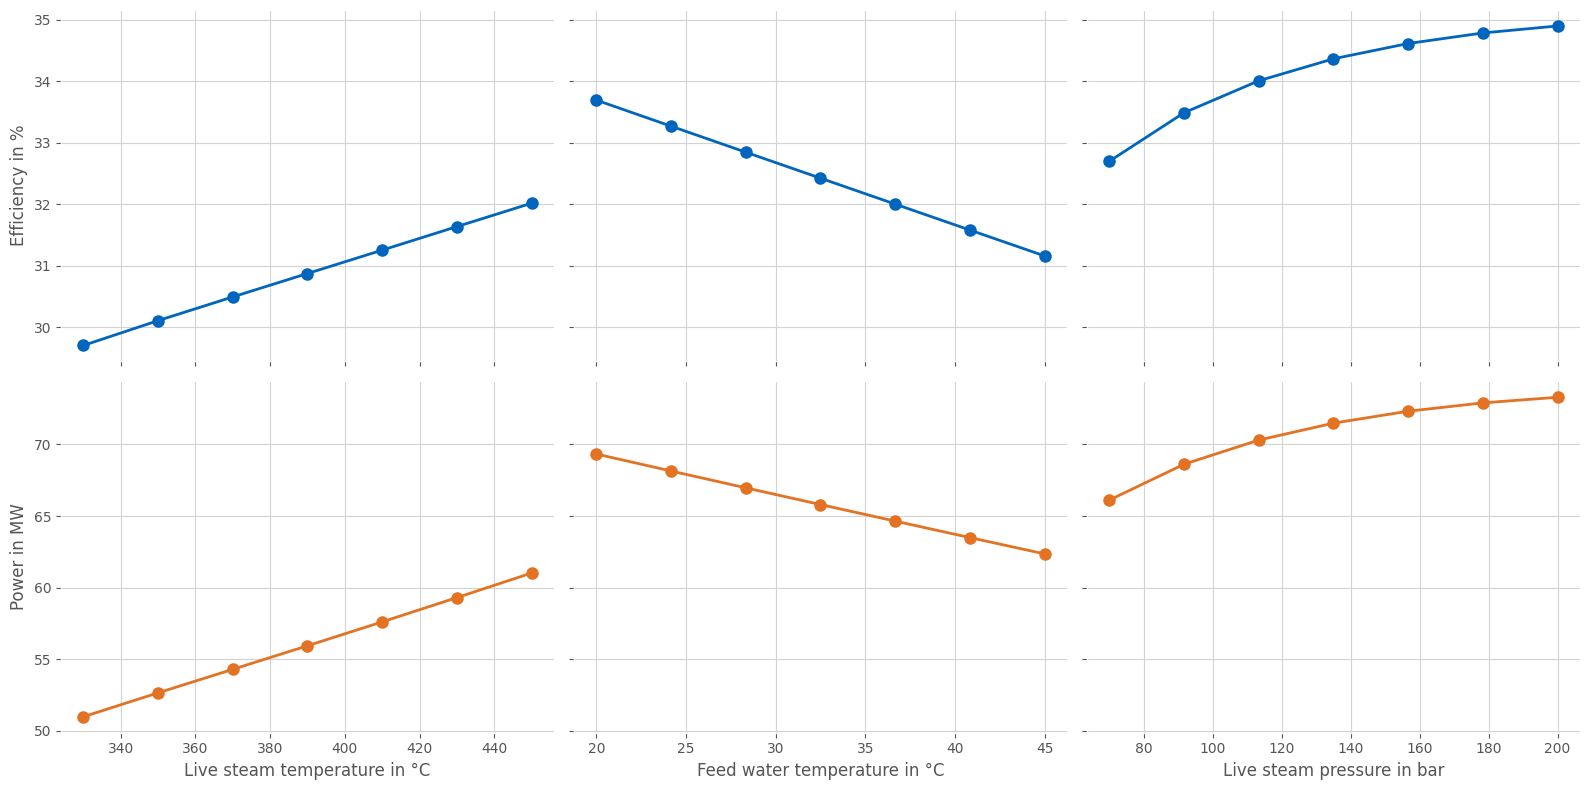

In [61]:
import numpy as np

rankine.set_attr(iterinfo=False)

# make text reasonably sized
plt.rc('font', **{'size': 18})

data = {
    'T_livesteam': np.linspace(330, 450, 7),
    'T_cooling': np.linspace(20, 45, 7),
    'p_livesteam': np.linspace(70, 200, 7)
}
eta = {
    'T_livesteam': [],
    'T_cooling': [],
    'p_livesteam': []
}
power = {
    'T_livesteam': [],
    'T_cooling': [],
    'p_livesteam': []
}

for T in data['T_livesteam']:
    c1.set_attr(T=T)
    c3.set_attr(T=T-1)
    rankine.solve('design')
    eta['T_livesteam'] += [abs(e7.E.val) / (sg.Q.val + sgre.Q.val) * 100]
    power['T_livesteam'] += [abs(e7.E.val) / 1e6]

# reset to base temperature
c1.set_attr(T=T_tu_in)
c3.set_attr(T=T_tu_in-1)
mc.set_attr(ttd_u=4)        # Set to a DT of 4 otherwise conflicts in the condenser
c4.set_attr(p=None)

for T in data['T_cooling']:
    c12.set_attr(T=T + 10)
    c11.set_attr(T=T)
    rankine.solve('design')
    eta['T_cooling'] += [abs(e7.E.val) / (sg.Q.val + sgre.Q.val) * 100]
    power['T_cooling'] += [abs(e7.E.val) / 1e6]

# reset to base temperature and pressure output
mc.set_attr(ttd_u=None)
c12.set_attr(T=T_coo_out)
c11.set_attr(T=T_coo_in)
c4.set_attr(p=p_tu_out)

for p in data['p_livesteam']:
    c1.set_attr(p=p)
    rankine.solve('design')
    eta['p_livesteam'] += [abs(e7.E.val) / (sg.Q.val + sgre.Q.val) * 100]
    power['p_livesteam'] += [abs(e7.E.val) / 1e6]

# reset to base pressure
c1.set_attr(p=p_tu_in)

with mplstyle.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex='col', sharey='row')    
    ax = ax.flatten()
    [a.grid() for a in ax]
    
    i = 0
    for key in data:
        # Plotting lines
        ax[i].plot(data[key], eta[key], marker='o', linestyle='-', color="#0065bd", markersize=8,
            linewidth=2)
        ax[i].set_facecolor('white')
        ax[i].grid(True, color="#D3D3D3")
        ax[i + 3].plot(data[key], power[key], marker='o', linestyle='-', color="#e37222", markersize=8,
            linewidth=2)
        ax[i + 3].set_facecolor('white')
        ax[i + 3].grid(True, color="#D3D3D3")
        i += 1
        
    ax[0].set_ylabel('Efficiency in %')
    ax[3].set_ylabel('Power in MW')
    ax[3].set_xlabel('Live steam temperature in °C')
    ax[4].set_xlabel('Feed water temperature in °C')
    ax[5].set_xlabel('Live steam pressure in bar')
    plt.tight_layout()
    plt.savefig(r"figs\Boundaries.svg", format='svg', dpi=300)
    plt.show()